## Structural clustering MHC Class I bound peptides using voxel representations and HDBSCAN

### Aims

### Method

### Results

### Conclusions

### Caveats/notes

### 1. Importing libraries and functions and loading configuration


In [3]:
# imports used in the notebook

import json
import os
import requests
import time
import hashlib

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['axes.facecolor'] = 'white'

from hdbscan import HDBSCAN

from functions.helpers import load_config, deslugify_allele, get_max_count, percentage, tensorize
from functions.structures import fetch_structure_info, download_structure, load_pdb_file_to_dataframe, calculate_max_rmsd_for_cluster
from functions.voxels import create_voxel_grid, find_voxels_for_structure, neighbour_distance



# load the config file to populate the configuration variables dictionary
# Note: if you change the shape and parameters of the voxel map, you will need to update the config file with the new voxel_map_hash

config = load_config()

# output the config file to the console
config

{'canonical_pdb_code': '1hhk',
 'centre_of_mass': [-42.365, 56.031, 63.67],
 'excluded_structures': ['2gtw', '4lcy'],
 'test_pdb_codes': ['1hhg', '1hhi', '1hhj', '1hhk'],
 'voxel_size': 1,
 'box_xyz': [36, 20, 20],
 'base_url': 'https://coordinates.histo.fyi/structures/downloads/class_i/without_solvent',
 'offsets': {'x': 0, 'y': 0, 'z': 0},
 'voxel_map_hash': 'e91d9bdc62da8457549cfbeed4c2b0aa'}

## 2. Fetch the structures to be clustered. 


In [4]:
sql_query = "select pdb_code, locus, allele_slug, peptide_sequence, resolution from core where peptide_length='9' and peptide_features='correct_sequence_and_length' and complex_type='class_i_with_peptide' and (locus='hla-a' or locus='hla-b' or locus='hla-c') order by resolution asc"

# the only_highest_resolution flag is set to False, so all structures will be returned, not just the highest resolution ones
structure_info = fetch_structure_info(sql_query, config['excluded_structures'], only_highest_resolution=False)

print (structure_info['metadata'])

print (f"There are {len(structure_info['structures'])} structures in the dataset.")

# TODO add a check to make sure that we're not removing structures with different conformations. 
# TODO add in getting more structures to test (e.g. if there are _1, _2, etc. structures, get those too)
# TODO add in some way of checking alternate atom locations (e.g. A, B, C, etc.)

if structure_info['metadata']['only_highest_resolution']:
    print (f"{structure_info['metadata']['original_structure_count'] - structure_info['metadata']['only_highest_resolution_count']} lower resolution duplicate structures have been removed.")

pdb_code_list = list(structure_info['structures'].keys())




{'excluded_structures': ['2gtw', '4lcy'], 'sql_query': "select pdb_code, locus, allele_slug, peptide_sequence, resolution from core where peptide_length='9' and peptide_features='correct_sequence_and_length' and complex_type='class_i_with_peptide' and (locus='hla-a' or locus='hla-b' or locus='hla-c') order by resolution asc", 'original_structure_count': 332, 'only_highest_resolution_count': None, 'only_highest_resolution': False}
There are 332 structures in the dataset.


## 3. Analyse the diversity of the structures (or lack of it)

Unsurprisingly there are a lot of HLA-A*02:01 structures in the collection. So many so that HLA-B structures would outnumber HLA-A structures if they are removed. Obviously this is a significant bias and this should be considered when looking at clusters later in the notebook.

Number of structures containing HLA-A*02:01: 140




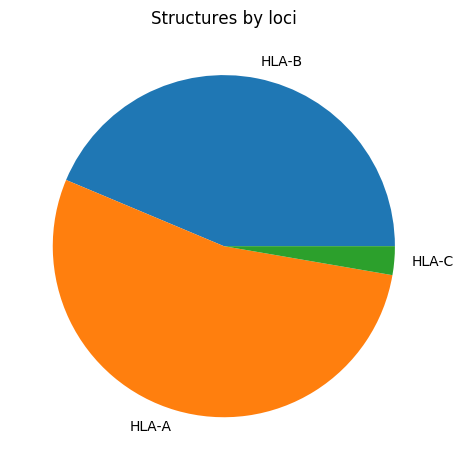

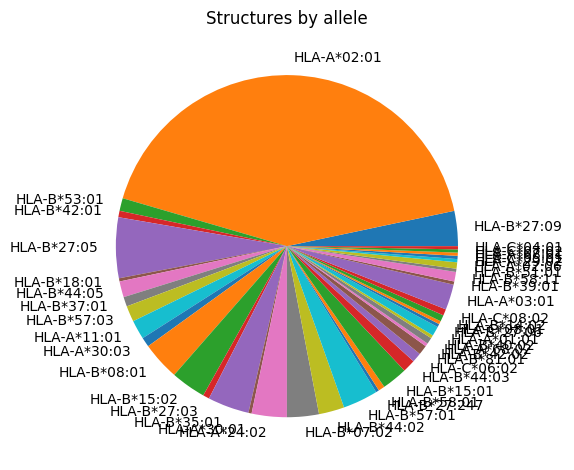

In [5]:
loci = {}
alleles = {}

for pdb_code in pdb_code_list:
  locus = structure_info['structures'][pdb_code]['locus']
  allele_slug = structure_info['structures'][pdb_code]['allele_slug']

  if locus not in loci:
    loci[locus] = 0
  loci[locus] += 1

  if allele_slug not in alleles:
    alleles[allele_slug] = 0
  alleles[allele_slug] += 1



# Create plots of number of structures per locus

fig, ax = plt.subplots()
ax.pie(loci.values(), labels=[locus.upper() for locus in loci.keys()])
ax.set_title('Structures by loci')
plt.tight_layout()

print (f"Number of structures containing HLA-A*02:01: {alleles['hla_a_02_01']}\n\n")

# Create plots of number of structures per allele

fig, ax = plt.subplots()
ax.pie(alleles.values(), labels=[deslugify_allele(allele_slug) for allele_slug in alleles.keys()])
ax.set_title('Structures by allele')
plt.tight_layout()



## 4. Looking at peptide diversity in the set of structures

Some peptides sequences are represented in structures with multiple alleles. Some peptides have structures with similar peptide sequences.

We're going to use the IEDB Cluster API to give us a data table of peptide clusters. 

Then we're going to process that to look at the number of structures for that particular peptide cluster. 

Then we're going to plot those clusters by cluster size and number of structures in that cluster. 



In [6]:



peptide_dict = {}

for pdb_code in pdb_code_list:
  peptide = structure_info['structures'][pdb_code]['peptide']
  if peptide not in peptide_dict:
    peptide_dict[peptide] = []
  peptide_dict[peptide].append(pdb_code)

sequences = list(peptide_dict.keys())

print (f"There are {len(sequences)} unique peptide sequences in the dataset.")

iedb_url = "https://api-nextgen-tools.iedb.org/api/v1/pipeline"

iedb_payload = {
  "pipeline_id": "",
  "run_stage_range": [
    1,
    1
  ],
  "stages": [
    {
      "name": "Cluster",
      "stage_number": 1,
      "tool_group": "cluster",
      "input_sequence_text": '\n'.join(sequences),
      "input_parameters": {
        "cluster_pct_identity": 0.5,
        "peptide_length_range": [
          9,
          9
        ],
        "predictors": [
          {
            "type": "cluster",
            "method": "cliques"
          }
        ]
      }
    }
  ]
}

iedb_response = requests.post(iedb_url, json=iedb_payload)

iedb_response_json = iedb_response.json()

iedb_results_uri = iedb_response_json['results_uri']

print (f"IEDB clustering job '{iedb_response_json['result_id']}' started.")

iedb_results_json = {'status': 'running'}

while iedb_results_json['status'] != 'done':
  iedb_results = requests.get(iedb_results_uri)
  iedb_results_json = iedb_results.json()

  print (f"IEDB clustering job '{iedb_results_json['id']}' is {iedb_results_json['status']}")

  if iedb_results_json['status'] in ['started', 'pending']:
    time.sleep(5)




There are 238 unique peptide sequences in the dataset.
IEDB clustering job 'cebb18a0-147b-4342-a87f-303d67a26ee2' started.
IEDB clustering job 'cebb18a0-147b-4342-a87f-303d67a26ee2' is pending
IEDB clustering job 'cebb18a0-147b-4342-a87f-303d67a26ee2' is pending
IEDB clustering job 'cebb18a0-147b-4342-a87f-303d67a26ee2' is pending
IEDB clustering job 'cebb18a0-147b-4342-a87f-303d67a26ee2' is done


262


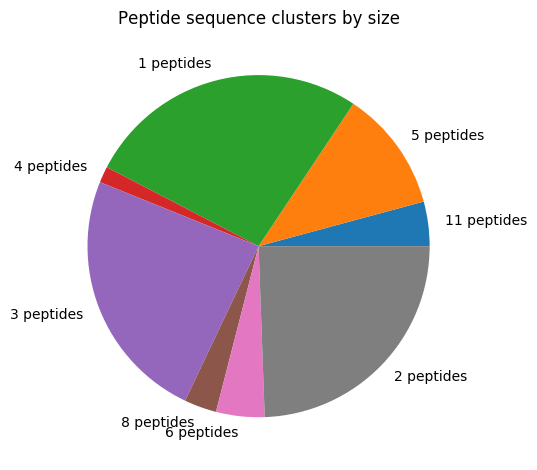

In [7]:
table_data = iedb_results.json()['data']['results'][0]['table_data']

raw_clusters = {}

cluster_sizes = {}

peptide_count = 0

for row in table_data:
    cluster_id = row[0]
    if not cluster_id in raw_clusters:
        raw_clusters[cluster_id] = {'consensus': None, 'members': [], 'size': 0}
    if not 'Consensus' in row[1]:
        if not row[2] in raw_clusters[cluster_id]['members']:
            raw_clusters[cluster_id]['members'].append(row[2])
            raw_clusters[cluster_id]['size'] += 1
            peptide_count += 1
    else:
        raw_clusters[cluster_id]['consensus'] = row[2]
    

print (peptide_count)

for cluster in raw_clusters:
    cluster_size = raw_clusters[cluster]['size']
    if not cluster_size in cluster_sizes:
        cluster_sizes[cluster_size] = {'count': 0, 'canonicals': [], 'total': 0}
    cluster_sizes[cluster_size]['count'] += 1
    if raw_clusters[cluster]['consensus']:
        cluster_sizes[cluster_size]['canonicals'].append(raw_clusters[cluster]['consensus'])
        
    else:
        cluster_sizes[cluster_size]['canonicals'].append(raw_clusters[cluster]['members'][0])
    cluster_sizes[cluster_size]['total'] += cluster_size


labels = [f"{item} peptides" for item in list(cluster_sizes.keys())]
sizes = [cluster_sizes[label]['total'] for label in list(cluster_sizes.keys())]

labels, sizes

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.set_title('Peptide sequence clusters by size')
plt.tight_layout()


## 5. Creating the voxel grid



In [8]:
# create the voxel grid, we only need to do this once, so it's outside the loop
voxel_grid = create_voxel_grid(config['centre_of_mass'], config['box_xyz'], config['voxel_size'], range_offset=1, y_offset=8)

voxel_grid_hash = hashlib.md5(str(voxel_grid).encode()).hexdigest()

voxel_set_filepath = f"output/voxel_sets/{voxel_grid_hash}"

if not os.path.exists(voxel_set_filepath):
    os.mkdir(voxel_set_filepath)
    print (f"Created directory {voxel_set_filepath}\n")

with open(f"{voxel_set_filepath}/voxel_set.json", 'w') as filehandle:
    json.dump(voxel_grid, filehandle, indent=4)
    print (f"Voxel set saved to {voxel_set_filepath}/voxel_set.json\n")

print (f"Voxel set hash for this grid is: {voxel_grid_hash}")



Voxel set saved to output/voxel_sets/e91d9bdc62da8457549cfbeed4c2b0aa/voxel_set.json

Voxel set hash for this grid is: e91d9bdc62da8457549cfbeed4c2b0aa


## 6. Downloading the structures

In [9]:
structure_count = 0
download_count = 0
cached_count = 0
errors = []

structure_dataset = {}

for pdb_code in pdb_code_list:
    structure_data, downloaded, cached, error  = download_structure(pdb_code, config)
    if downloaded:
        download_count += 1
    if cached:
        cached_count += 1
    if error:
        print (error)
        errors.append(pdb_code)
    else:
        structure_dataset[pdb_code] = structure_data
    structure_count += 1

print (f"{structure_count} structures were processed. {download_count} structures were downloaded, {cached_count} structures were already downloaded, and {len(errors)} errors occurred.")


332 structures were processed. 0 structures were downloaded, 332 structures were already downloaded, and 0 errors occurred.


## 7. Processing the structures (finding the occupied voxels) 

In [10]:
voxelized_structures = []

structure_voxel_collection = {}
used_voxel_collection = {}
position_voxel_collection = {}
occupied_voxel_list = []

# iterate through the test PDB codes
for pdb_code in pdb_code_list:

    # load the peptide dataframe for the PDB code
    dataframe = load_pdb_file_to_dataframe(pdb_code, 'peptide', config)
    
    if dataframe:
    # if the dataframe is not None, find the voxels for the structure and write them to a file
        structure_voxels = find_voxels_for_structure(dataframe, voxel_grid['voxels'], voxel_size=config['voxel_size'])

        voxel_data = {
            'voxel_grid_hash': voxel_grid_hash,
            'structure_voxels': structure_voxels
        }

        filename = f"{voxel_set_filepath}/{pdb_code}.json"

        with open(filename, 'w') as filehandle:
            json.dump(voxel_data, filehandle, indent=4)
        voxelized_structures.append(pdb_code)

        structure_voxel_collection[pdb_code] = structure_voxels

        used_voxels = [structure_voxels[position]['voxel_label'] for position in structure_voxels]
        used_voxel_collection[pdb_code] = used_voxels

        position = 1
        for voxel_label in used_voxels:
            if position not in position_voxel_collection:
                position_voxel_collection[position] = {}
            if voxel_label not in position_voxel_collection[position]:
                position_voxel_collection[position][voxel_label] = {'count':0,'members':[]}
            if pdb_code not in position_voxel_collection[position][voxel_label]['members']:
                position_voxel_collection[position][voxel_label]['members'].append(pdb_code)
                position_voxel_collection[position][voxel_label]['count'] += 1
            if voxel_label not in occupied_voxel_list:
                occupied_voxel_list.append(voxel_label)
            position += 1


print (f"{len(structure_voxel_collection)} structures were processed and saved to {voxel_set_filepath}")
print (f"There are {len(occupied_voxel_list)} different voxels used.")

332 structures were processed and saved to output/voxel_sets/e91d9bdc62da8457549cfbeed4c2b0aa
There are 206 different voxels used.


## 8. Looking at positional voxel occupancy


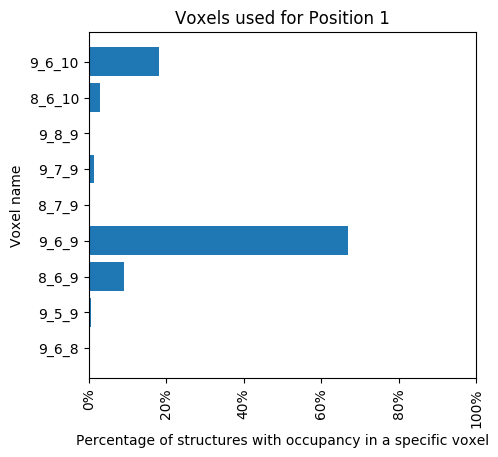

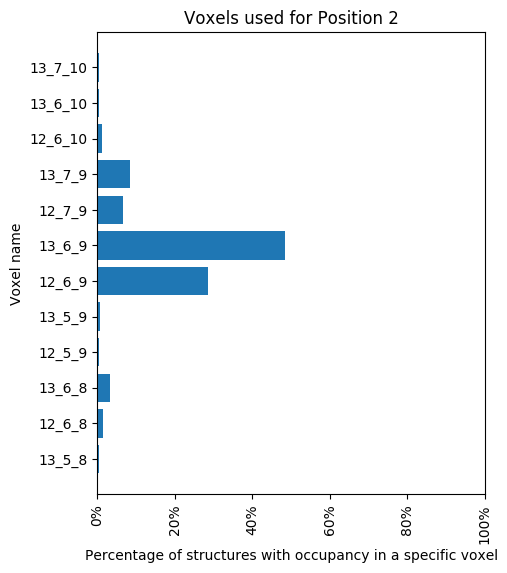

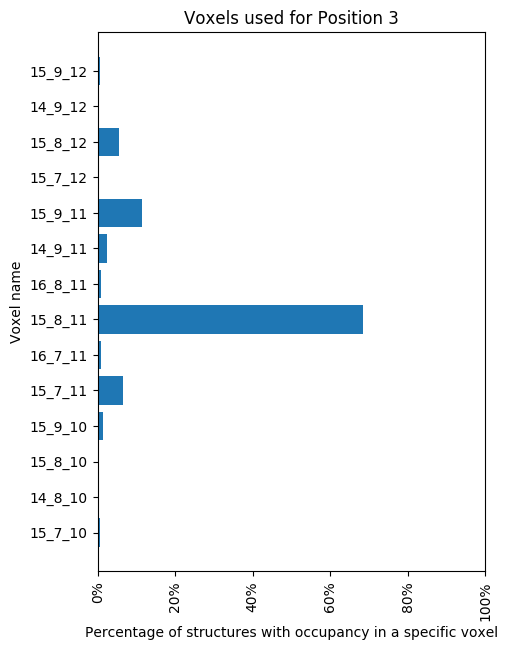

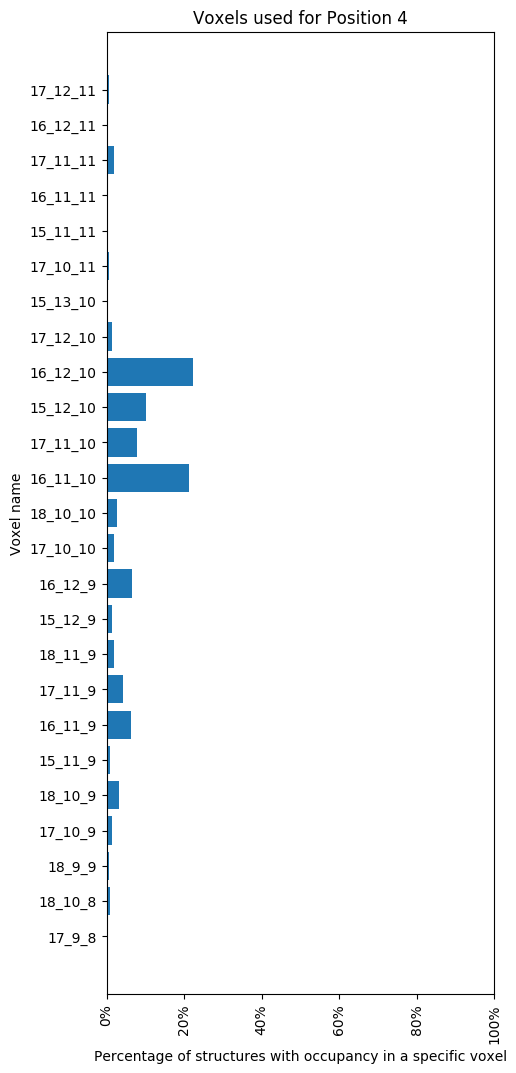

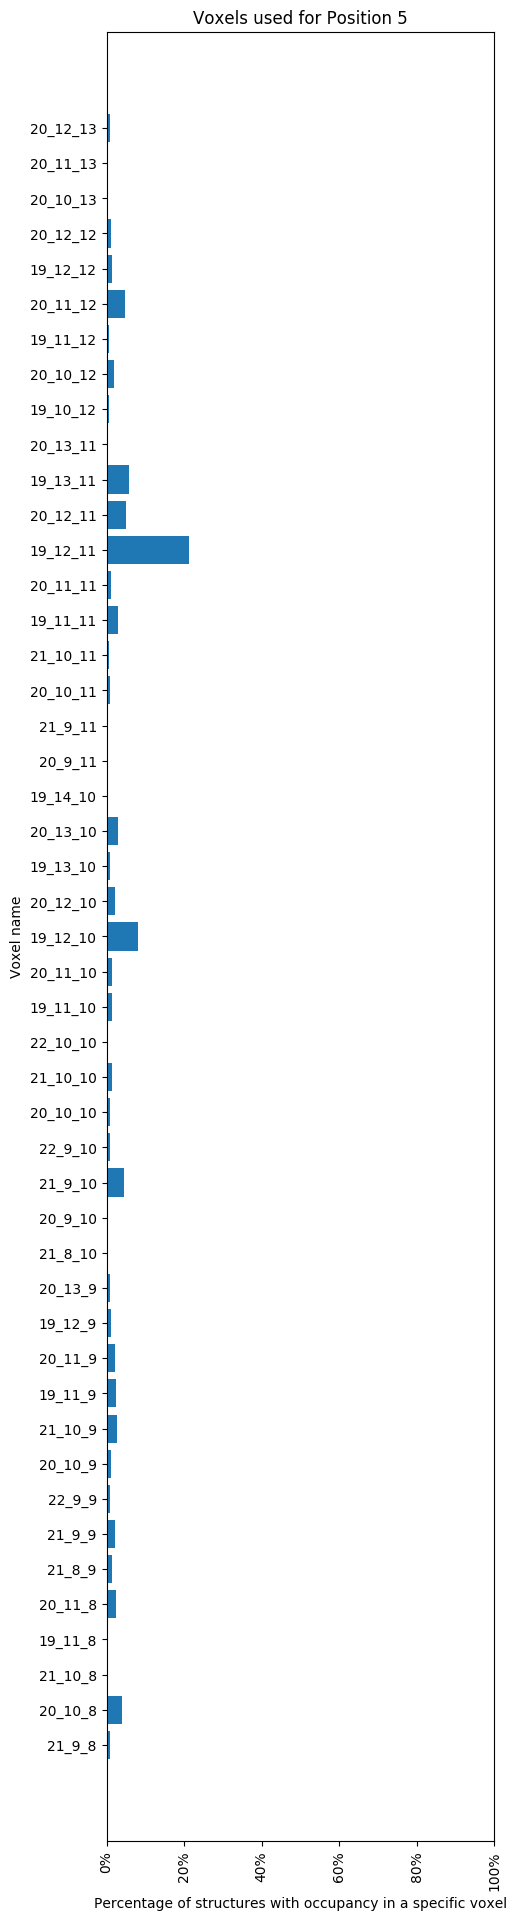

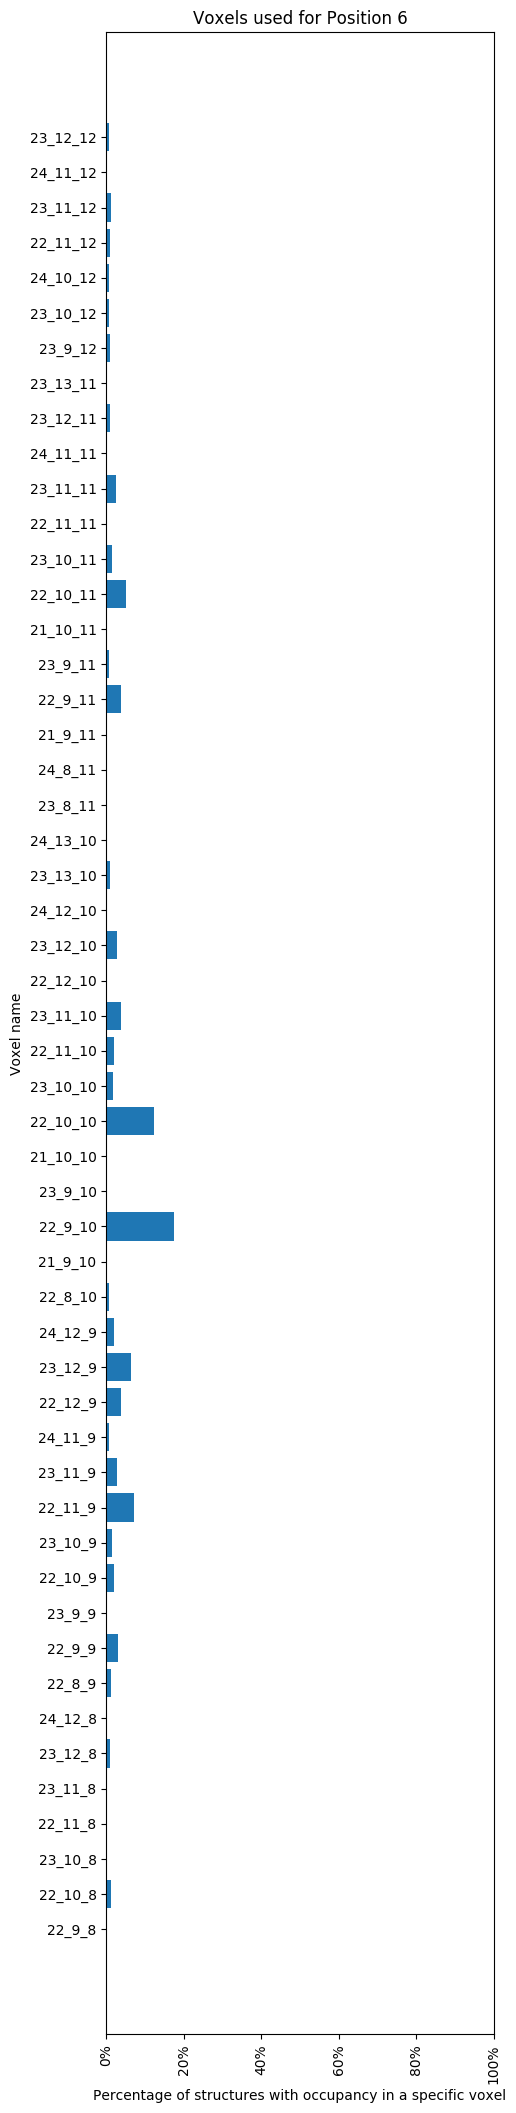

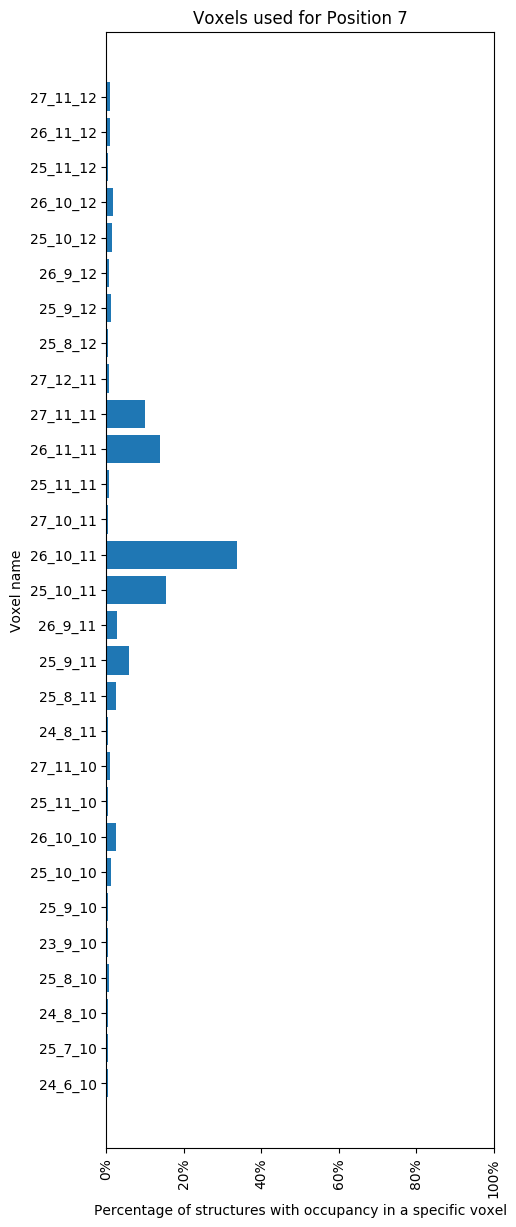

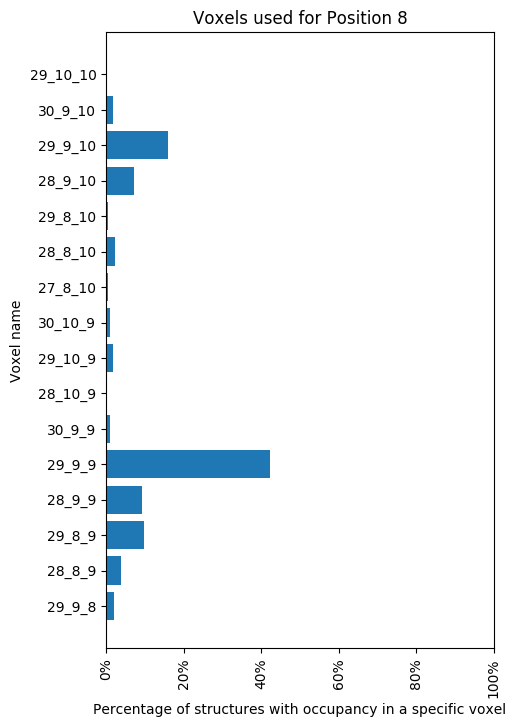

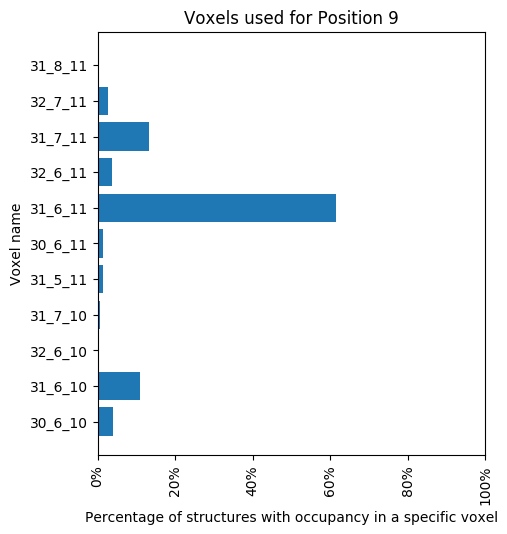

In [11]:
all_used_voxels = []

image_format = 'svg'

for position in position_voxel_collection:

    position_voxel_names = [voxel_name for voxel_name in voxel_grid['voxels'].keys() if voxel_name in position_voxel_collection[position]]

    all_used_voxels += position_voxel_names

    used_voxel_count = [position_voxel_collection[position][voxel_name]['count']/structure_count * 100 for voxel_name in position_voxel_names]

    plt.figure(figsize=(5, 0.5 * len(used_voxel_count)))
    plt.barh(position_voxel_names, used_voxel_count, color='tab:blue')

    plt.title(f"Voxels used for Position {position}")
    plt.ylabel("Voxel name")
    plt.xlabel("Percentage of structures with occupancy in a specific voxel")
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
    plt.xlim(0, 100)
    plt.xticks(rotation=90)

    image_name = f"output/plots/position_{position}_voxel_occupancy.svg"
    plt.savefig(image_name, format=image_format, dpi=1200)

    plt.show()
    plt.close()



## 9. Looking at occupancy of neighbouring voxels

This well known picture of stability at the N- and C- terminal positions can be seen in greater clarity when considering not merely the modal voxel, but also the neighbouring voxels. 

* TODO categorize neighbours as face, edge and vertex connected voxels.

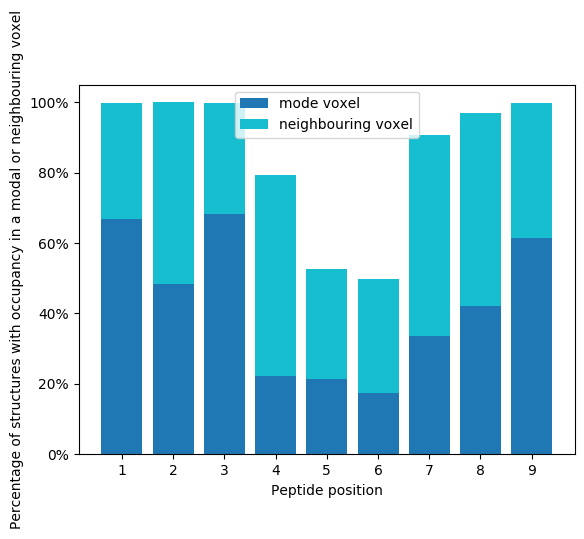


Position 1
{'mode_percentage': 66.87, 'neighbour_percentage': 32.83, 'mode_and_neighbour_percentage': 99.7}

Position 2
{'mode_percentage': 48.49, 'neighbour_percentage': 51.51, 'mode_and_neighbour_percentage': 100.0}

Position 3
{'mode_percentage': 68.37, 'neighbour_percentage': 31.33, 'mode_and_neighbour_percentage': 99.7}

Position 4
{'mode_percentage': 22.29, 'neighbour_percentage': 56.93, 'mode_and_neighbour_percentage': 79.22}

Position 5
{'mode_percentage': 21.39, 'neighbour_percentage': 31.33, 'mode_and_neighbour_percentage': 52.71}

Position 6
{'mode_percentage': 17.47, 'neighbour_percentage': 32.23, 'mode_and_neighbour_percentage': 49.7}

Position 7
{'mode_percentage': 33.73, 'neighbour_percentage': 56.93, 'mode_and_neighbour_percentage': 90.66}

Position 8
{'mode_percentage': 42.17, 'neighbour_percentage': 54.82, 'mode_and_neighbour_percentage': 96.99}

Position 9
{'mode_percentage': 61.45, 'neighbour_percentage': 38.25, 'mode_and_neighbour_percentage': 99.7}


In [12]:
position_mode_set = {}


labels = []
mode_percentages = []
neighbour_percentages = []

for position in position_voxel_collection:

  neighbour_count = 0
  labels.append(position)
  mode_voxel_info = get_max_count(position_voxel_collection[position])
  mode_voxel_name = mode_voxel_info['max_voxel_used']
  mode_voxel_count = mode_voxel_info['count']

  position_mode_set[position] = {
      'modal_voxel': {
          'voxel_name':mode_voxel_name,
          'count':mode_voxel_count
      },
      'neighbour_voxels':[],
      'stats':{}
  }

  mode_percentage = percentage(mode_voxel_count, structure_count)

  mode_percentages.append(mode_percentage)

  position_mode_set[position]['stats']['mode_percentage'] = mode_percentage

  mode_and_neighbour_count = get_max_count(position_voxel_collection[position])['count']
  for voxel in position_voxel_collection[position]:
    if voxel != mode_voxel_name:
      if neighbour_distance(voxel, mode_voxel_name) < 1.5:
        neighbour_voxel = {
            'voxel_name': voxel,
            'count': position_voxel_collection[position][voxel]['count']
        }
        neighbour_count += position_voxel_collection[position][voxel]['count']
      position_mode_set[position]['neighbour_voxels'].append(neighbour_voxel)
  mode_and_neighbour_count += neighbour_count
  mode_and_neighbour_percentage = percentage(mode_and_neighbour_count, structure_count )

  neighbour_percentage = percentage(neighbour_count, structure_count)
  neighbour_percentages.append(neighbour_percentage)
  position_mode_set[position]['stats']['neighbour_percentage'] = neighbour_percentage
  position_mode_set[position]['stats']['mode_and_neighbour_percentage'] = mode_and_neighbour_percentage



plt.bar(labels, mode_percentages, color='tab:blue')
plt.bar(labels, neighbour_percentages, bottom=mode_percentages, color='tab:cyan')
plt.xlabel("Peptide position")
plt.ylabel("Percentage of structures with occupancy in a modal or neighbouring voxel")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
plt.xticks(labels)
plt.legend(['mode voxel','neighbouring voxel'])

image_format = 'svg'
image_name = 'output/plots/mode_and_neighbours.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

for position in position_mode_set:
  print (f"\nPosition {position}")
  print (position_mode_set[position]['stats'])


## 10. Clustering the voxels using HDBSCAN

In [13]:

possible_clustering_positions = [[4,5], [4,6], [4,7], [5,6] ,[5,7], [6,7], [4,5,6], [5,6,7], [4,5,6,7], [1,2,3,4,5,6,7,8,9]]

min_cluster_size = 3

clustering_collection = {}

used_voxel_tensors = [tensorize(voxel_labels) for voxel_labels in used_voxel_collection.values()]

structure_labels = list(used_voxel_collection.keys())

clustering_collection = {
    'clusters': {},
    'structure_labels':structure_labels,
    'structure_count':len(structure_labels)
}

clusters_path = f"output/clusters/{voxel_grid_hash}"

if not os.path.exists(clusters_path):
    os.mkdir(clusters_path)

cluster_sizes_path = f"{clusters_path}/cluster_size_{min_cluster_size}"

if not os.path.exists(cluster_sizes_path):
    os.mkdir(cluster_sizes_path)

for clustering_position_set in possible_clustering_positions:
    cluster_positions_str = '_'.join([str(position) for position in clustering_position_set])
    
    print (f"Clustering on {clustering_position_set} with minimum cluster size {min_cluster_size}")
    clustering_data = []

    for row in used_voxel_tensors:
        p = 1
        processed_row = []
        for position in row:
            if p in clustering_position_set:

                for item in position:
                    processed_row.append(item)
                
            p += 1
        clustering_data.append(processed_row)
    
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    hdb.fit(clustering_data)

    cluster_sizes = Counter(hdb.labels_)
    cluster_sizes.pop(-1, None)

    clusters = {}
    noise_cluster = []

    for cluster in set(hdb.labels_):
        if cluster != -1:
            clusters[str(cluster + 1)] = [structure_labels[i] for i in range(len(hdb.labels_)) if hdb.labels_[i] == cluster]
        else:
            noise_cluster = [structure_labels[i] for i in range(len(hdb.labels_)) if hdb.labels_[i] == -1]

        all_clusters_rmsds = {}
        for cluster_number in clusters:
            cluster_members = clusters[cluster_number]

            cluster_max_rmsd = calculate_max_rmsd_for_cluster(cluster_members, structure_voxel_collection)

            all_clusters_rmsds[cluster_number] = cluster_max_rmsd

      

    noise_cluster_max_rmsd = calculate_max_rmsd_for_cluster(noise_cluster, structure_voxel_collection)

    all_clusters_rmsds['noise'] = noise_cluster_max_rmsd

    print (f"Number of clusters: {len(clusters)} | Number of structures in the noise cluster: {len(noise_cluster)}")

    cluster_max_rmsds = [all_clusters_rmsds[cluster] for cluster in all_clusters_rmsds if cluster != 'noise']

    print (cluster_max_rmsds)

    print (f"Max RMSD {max(cluster_max_rmsds)}")    

    average_cluster_all_position_rmsd = round(sum([all_clusters_rmsds[cluster] for cluster in all_clusters_rmsds]) / len(all_clusters_rmsds), 2)
    
    print (f"Avg max RMSD for all positions: {average_cluster_all_position_rmsd}")

    print (f"Noise cluster for all positions max RMSD: {noise_cluster_max_rmsd}")
    
    print ('')


    clustering_collection['clusters'][cluster_positions_str] = {
        'clustering_positions':clustering_position_set,
        'cluster_count':len(set(hdb.labels_)) -1,
        'noise_cluster_size': list(hdb.labels_).count(-1),
        'min_cluster_size': min(cluster_sizes.values()),
        'max_cluster_size': max(cluster_sizes.values()),
        'mean_cluster_size':round(sum(cluster_sizes.values()) / len(cluster_sizes),1),
        'max_rmsd':average_cluster_all_position_rmsd,
        'cluster_max_rmsds':cluster_max_rmsds,
        'noise_cluster_max_rmsd':noise_cluster_max_rmsd,
        'noise_cluster':noise_cluster,
        'outlier_scores':[],
        'clusters':clusters
    }

    with open(f"{cluster_sizes_path}/clustering_{cluster_positions_str}.json", 'w') as filehandle:
        json.dump(clustering_collection['clusters'][cluster_positions_str], filehandle, indent=4)




#print (clustering_collection)

Clustering on [4, 5] with minimum cluster size 3
Number of clusters: 24 | Number of structures in the noise cluster: 77
[2.4253245830884897, 0.3053577137282341, 1.6848356992102618, 1.6997714552256702, 0.9011697953216086, 2.0385555343592374, 2.3454428153335964, 0.38174598884598715, 1.2289243263927991, 0.8201272259025908, 1.9543324521005485, 0.9666386777557283, 1.161813811818976, 1.352514325247614, 1.1629855258485917, 1.053032129930835, 0.8763055022840678, 1.5739183587467334, 1.9215363644750563, 1.1860942907992864, 0.5443757893220462, 1.0052744235613833, 2.174215644012034, 2.065001129943196]
Max RMSD 2.4253245830884897
Avg max RMSD for all positions: 1.42
Noise cluster for all positions max RMSD: 2.750259624108242

Clustering on [4, 6] with minimum cluster size 3
Number of clusters: 34 | Number of structures in the noise cluster: 117
[0.17672106080864725, 0.68875346339117, 1.183832195315987, 1.9550674327671331, 1.3954327883014166, 0.8054733597912043, 1.0452704594186786, 0.717467304713831

## 11. Selecting the best set of clusters

Criteria

- low number of structures in the "noise" cluster
- lowest max RMSD vs noise max RMS

Others to potentially add
- similar voxel useage within the cluster
- higher average RMSD between clusters?



4_5
Score: 109.34 | Noise cluster size: 77 | Cluster count: 24 | Max RMSD: 1.42 | Max noise RMSD: 2.750259624108242
4_6
Score: 121.68 | Noise cluster size: 117 | Cluster count: 34 | Max RMSD: 1.04 | Max noise RMSD: 2.863924405426929
4_7
Score: 131.04 | Noise cluster size: 78 | Cluster count: 28 | Max RMSD: 1.68 | Max noise RMSD: 3.195843811369174
5_6
Score: 95.4 | Noise cluster size: 106 | Cluster count: 26 | Max RMSD: 0.9 | Max noise RMSD: 2.863924405426929
5_7
Score: 110.67 | Noise cluster size: 93 | Cluster count: 34 | Max RMSD: 1.19 | Max noise RMSD: 3.3804211276111733
6_7
Score: 121.93 | Noise cluster size: 89 | Cluster count: 26 | Max RMSD: 1.37 | Max noise RMSD: 2.8547361816228594
4_5_6
Score: 85.02 | Noise cluster size: 109 | Cluster count: 34 | Max RMSD: 0.78 | Max noise RMSD: 2.7016486941618947
5_6_7
Score: 108.54 | Noise cluster size: 134 | Cluster count: 33 | Max RMSD: 0.81 | Max noise RMSD: 2.8547361816228594
4_5_6_7
Score: 105.4 | Noise cluster size: 155 | Cluster count: 

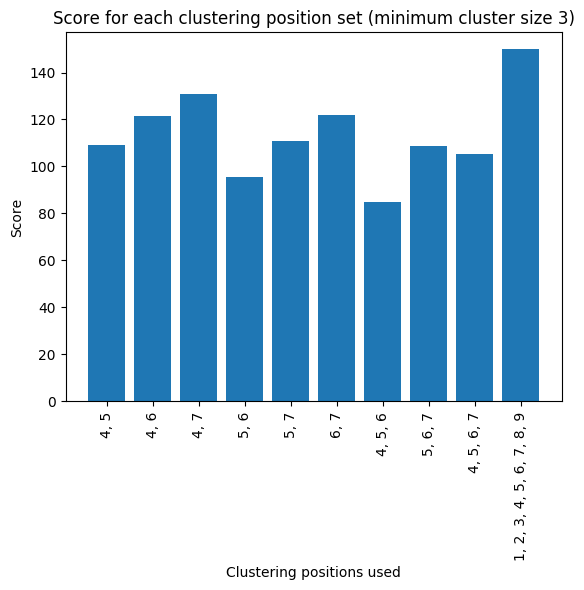

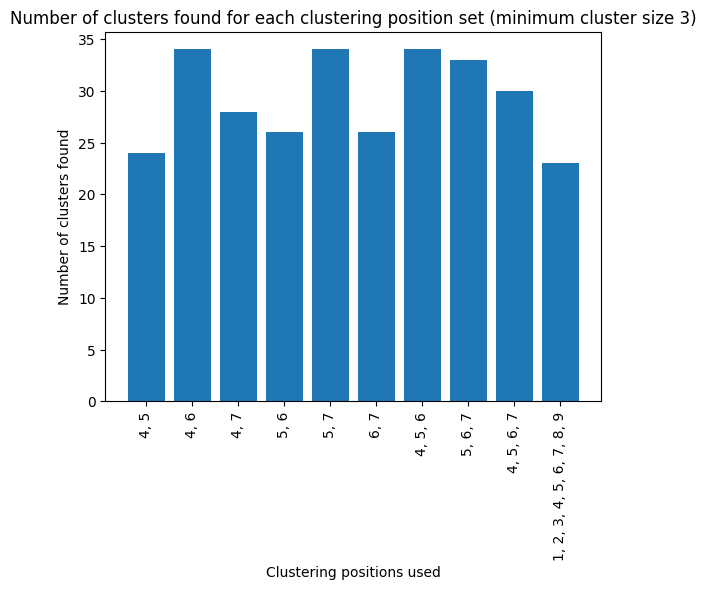

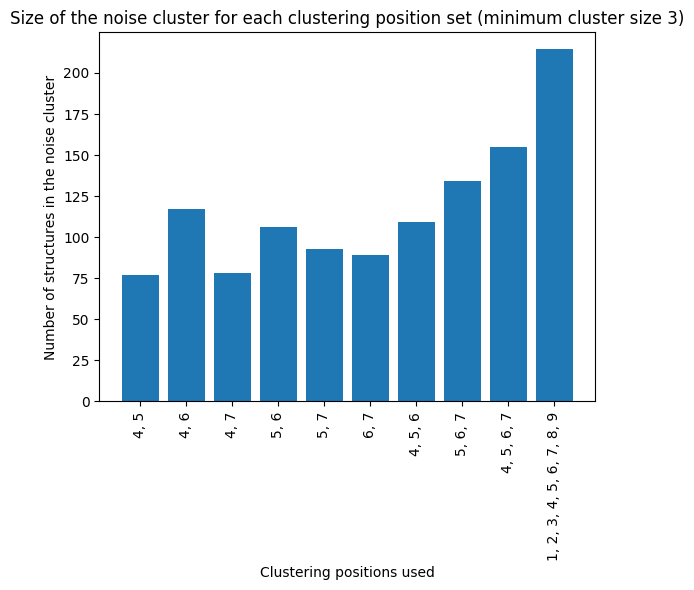

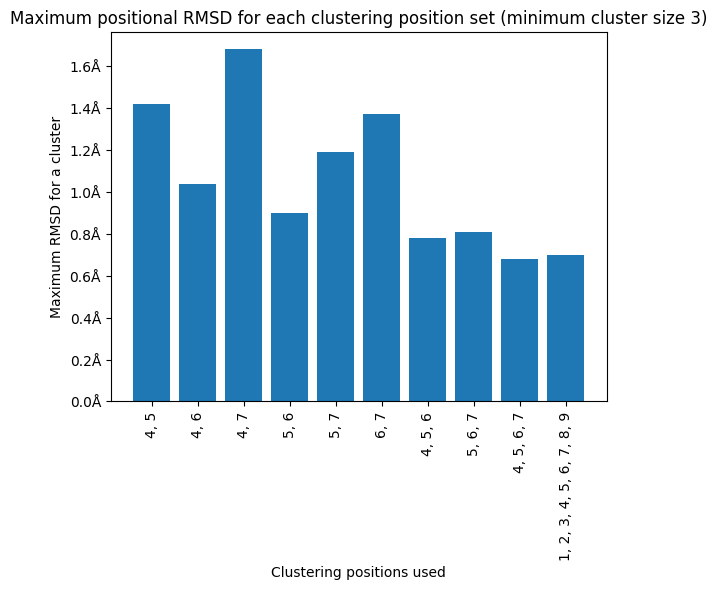

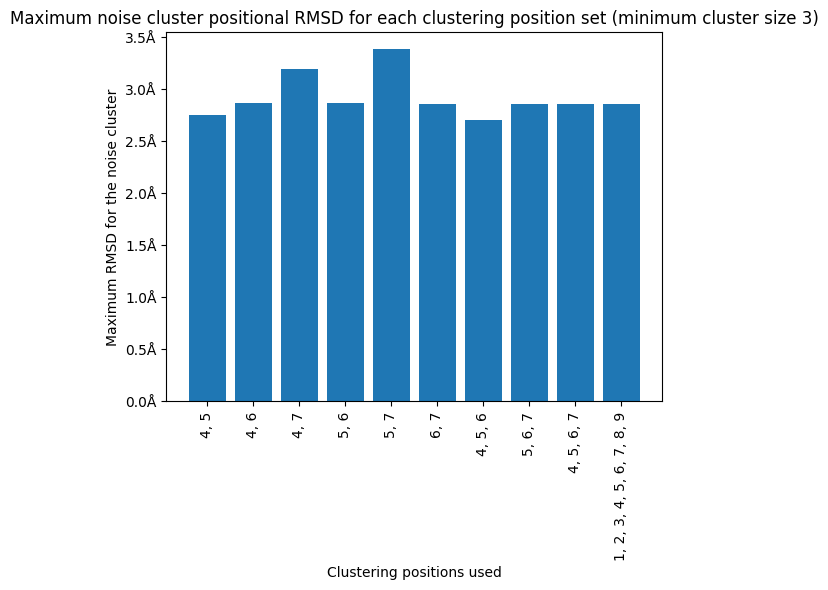

In [17]:
scores = []
labels = [item.replace('_',', ') for item in clustering_collection['clusters'].keys()]

for clustering in clustering_collection['clusters']:
    noise_cluster_size = clustering_collection['clusters'][clustering]['noise_cluster_size']
    cluster_count = clustering_collection['clusters'][clustering]['cluster_count']
    max_rmsd = clustering_collection['clusters'][clustering]['max_rmsd']
    max_noise_rmsd = clustering_collection['clusters'][clustering]['noise_cluster_max_rmsd']

    print (clustering)


    score = round(noise_cluster_size * max_rmsd, 2)
    scores.append(score)
    print (f"Score: {score} | Noise cluster size: {noise_cluster_size} | Cluster count: {cluster_count} | Max RMSD: {max_rmsd} | Max noise RMSD: {max_noise_rmsd}")

print (f"\nMinimum score is {min(scores)}")


plt.bar(labels, scores, color='tab:blue')
plt.title(f"Score for each clustering position set (minimum cluster size {min_cluster_size})")
plt.xlabel("Clustering positions used")
plt.ylabel("Score")
plt.xticks(rotation=90)

image_format = 'svg'
image_name = 'output/plots/scores.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

plt.close()



cluster_counts = [clustering_collection['clusters'][clustering]['cluster_count'] for clustering in clustering_collection['clusters']]


plt.bar(labels, cluster_counts, color='tab:blue')
plt.title(f"Number of clusters found for each clustering position set (minimum cluster size {min_cluster_size})")
plt.xlabel("Clustering positions used")
plt.ylabel("Number of clusters found")
plt.xticks(rotation=90)
plt.show()

noise_cluster_sizes = [clustering_collection['clusters'][clustering]['noise_cluster_size'] for clustering in clustering_collection['clusters']]

plt.bar(labels, noise_cluster_sizes, color='tab:blue')
plt.title(f"Size of the noise cluster for each clustering position set (minimum cluster size {min_cluster_size})")
plt.xlabel("Clustering positions used")
plt.ylabel("Number of structures in the noise cluster")
plt.xticks(rotation=90)
plt.show()

max_rmsds = [clustering_collection['clusters'][clustering]['max_rmsd'] for clustering in clustering_collection['clusters']]

plt.bar(labels, max_rmsds, color='tab:blue')
plt.title(f"Maximum positional RMSD for each clustering position set (minimum cluster size {min_cluster_size})")
plt.xlabel("Clustering positions used")
plt.ylabel("Maximum RMSD for a cluster")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.1f}Å'.format))
plt.xticks(rotation=90)
plt.show()

noise_cluster_max_rmsds = [clustering_collection['clusters'][clustering]['noise_cluster_max_rmsd'] for clustering in clustering_collection['clusters']]

plt.bar(labels, noise_cluster_max_rmsds, color='tab:blue')
plt.title(f"Maximum noise cluster positional RMSD for each clustering position set (minimum cluster size {min_cluster_size})")
plt.xlabel("Clustering positions used")
plt.ylabel("Maximum RMSD for the noise cluster")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.1f}Å'.format))
plt.xticks(rotation=90)
plt.show()




## 11. Analysing the peptide clusters

In [18]:
clustering_positions = [4,5,6]
print (f"Minimum cluster size {min_cluster_size} and clustering positions {clustering_positions}")

clustering_positions_string = '_'.join([str(position) for position in clustering_positions])


all_clusters_used_voxels = []

ordered_position_voxels = {}

for voxel in all_used_voxels:
    for position in position_voxel_collection:
        if not position in ordered_position_voxels:
            ordered_position_voxels[position] = []
        if voxel in position_voxel_collection[position]:
            ordered_position_voxels[position].append(voxel)

x_labels = []
ordered_voxel_list = []
for position in ordered_position_voxels:
    for voxel in ordered_position_voxels[position]:
        x_labels.append(f"P{position} {voxel}")
        ordered_voxel_list.append(voxel)

print (x_labels)


for cluster_number in clustering_collection['clusters'][clustering_positions_string]['clusters']:
    cluster = clustering_collection['clusters'][clustering_positions_string]['clusters'][cluster_number]
    cluster_size = len(cluster)
    cluster_voxels = {}

    for member in cluster:
        for voxel in used_voxel_collection[member]:
            if voxel not in cluster_voxels:
                cluster_voxels[voxel] = 0
            cluster_voxels[voxel] += 1

    cluster_used_voxels = []
    for voxel in ordered_voxel_list:
        if voxel not in cluster_voxels:
            cluster_used_voxels.append(np.nan)
        else:
            cluster_used_voxels.append(round(cluster_voxels[voxel] / cluster_size * 100, 2))
    all_clusters_used_voxels.append(cluster_used_voxels)

y_labels = [f"Cluster {cluster_number} ({len(clustering_collection['clusters'][clustering_positions_string]['clusters'][cluster_number])} members)" for cluster_number in clustering_collection['clusters'][clustering_positions_string]['clusters']]



import seaborn as sns

fig, ax = plt.subplots(figsize=(40,20))
cmap = sns.cm.rocket_r
hm = sns.heatmap(data = all_clusters_used_voxels, cmap=cmap, ax=ax, xticklabels=x_labels, yticklabels=y_labels) 
image_format = 'svg'
image_name = 'output/plots/heatmap.svg'

plt.savefig(image_name, format=image_format, dpi=600)
plt.show()

plt.close()

Minimum cluster size 3 and clustering positions [4, 5, 6]
['P1 9_6_8', 'P1 9_5_9', 'P1 8_6_9', 'P1 9_6_9', 'P1 8_7_9', 'P1 9_7_9', 'P1 9_8_9', 'P1 8_6_10', 'P1 9_6_10', 'P2 13_5_8', 'P2 12_6_8', 'P2 13_6_8', 'P2 12_5_9', 'P2 13_5_9', 'P2 12_6_9', 'P2 13_6_9', 'P2 12_7_9', 'P2 13_7_9', 'P2 12_6_10', 'P2 13_6_10', 'P2 13_7_10', 'P3 15_7_10', 'P3 14_8_10', 'P3 15_8_10', 'P3 15_9_10', 'P3 15_7_11', 'P3 16_7_11', 'P3 15_8_11', 'P3 16_8_11', 'P3 14_9_11', 'P3 15_9_11', 'P3 15_7_12', 'P3 15_8_12', 'P3 14_9_12', 'P3 15_9_12', 'P4 17_9_8', 'P4 18_10_8', 'P4 18_9_9', 'P4 17_10_9', 'P4 18_10_9', 'P4 15_11_9', 'P4 16_11_9', 'P4 17_11_9', 'P4 18_11_9', 'P4 15_12_9', 'P4 16_12_9', 'P4 17_10_10', 'P4 18_10_10', 'P4 16_11_10', 'P4 17_11_10', 'P4 15_12_10', 'P4 16_12_10', 'P4 17_12_10', 'P4 15_13_10', 'P4 17_10_11', 'P4 15_11_11', 'P4 16_11_11', 'P4 17_11_11', 'P4 16_12_11', 'P4 17_12_11', 'P5 21_9_8', 'P5 20_10_8', 'P5 21_10_8', 'P5 19_11_8', 'P5 20_11_8', 'P5 21_8_9', 'P5 21_9_9', 'P5 22_9_9', 'P5 20

: 

In [16]:
ordered_position_voxels = {}

for voxel in x_labels:
    for position in position_voxel_collection:
        if not position in ordered_position_voxels:
            ordered_position_voxels[position] = []
        if voxel in position_voxel_collection[position]:
            ordered_position_voxels[position].append(voxel)



xlabels = []
for position in ordered_position_voxels:
    xlabels += ordered_position_voxels[position]
    print (position)
    print (ordered_position_voxels[position][0], '|', ordered_position_voxels[position][-1])



1


IndexError: list index out of range

## 12. Displaying the peptide clusters

In [ ]:
# TODO work on this section, bring over from alphafold analysis notebook



## 13. Analysing the allele patterns within the peptide clusters

In [ ]:
# TODO work on this section 

## 14. Analysing the peptide patterns within the peptide clusters

In [ ]:
# TODO work on this section

## 15. Clusters of interest

### Notes:



## 16. Future directions

Look at side chain centre of mass as an additional factor/sub-classification
